# Building a Travel Planner with LangGraph: A Tutorial
### Overview
This notebook guides you through the process of creating a simple Travel Planner using LangGraph, a library for building stateful, multi-step applications with language models. The Travel Planner demonstrates how to structure a conversational AI application that collects user input and generates personalized travel itineraries.

### Motivation
In the realm of AI applications, managing state and flow in multi-step processes can be challenging. LangGraph provides a solution by allowing developers to create graph-based workflows that can handle complex interactions while maintaining a clear and modular structure. This Travel Planner serves as a practical example of how to leverage LangGraph's capabilities to build a useful and interactive application.

### Key Components
1. **StateGraph**: The core of our application, defining the flow of our Travel Planner.
2. **PlannerState**: A custom type representing the state of our planning process.
3. **Node Functions**: Individual steps in our planning process (input_city, input_interests, create_itinerary).
4. **LLM Integration**: Utilizing a language model to generate the final itinerary.

### Method Details
Our Travel Planner follows a straightforward, three-step process:

1. City Input:

  - The application prompts the user to enter the city they want to visit.
  - This information is stored in the state.
2. Interests Input:

  - The user is asked to provide their interests for the trip.
  - These interests are stored as a list in the state.
3. Itinerary Creation:

  - Using the collected city and interests, the application leverages a language model to generate a personalized day trip itinerary.
  - The generated itinerary is presented to the user.
The flow between these steps is managed by LangGraph, which handles the state transitions and ensures that each step is executed in the correct order.

### Conclusion
This notebook demonstrates how LangGraph can be used to create a simple yet effective Travel Planner. By structuring our application as a graph of interconnected nodes, we achieve a clear separation of concerns and a easily modifiable workflow. This approach can be extended to more complex applications, showcasing the power and flexibility of graph-based designs in AI-driven conversational interfaces.

The Travel Planner serves as a starting point for developers looking to build more sophisticated stateful applications using language models. It illustrates key concepts such as state management, user input handling, and integration with AI models, all within the framework provided by LangGraph.

##### Import required libraries

In [ ]:
!pip -q install langchain huggingface_hub  python-dotenv
!pip -q install sentence_transformers langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/

In [1]:
!pip -q install langchain_groq langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.5/152.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.4/131.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 9.5 MB/s eta 0:00:00


### Import necessary libraries

In [2]:
import os
from langchain_groq import ChatGroq
from typing import TypedDict, Dict, List, Annotated
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image
import re
from google.colab import userdata

os.environ["GROQ_API_KEY"] = userdata.get("GROQ_API_KEY")
# os.environ["OPEN_API_KEY"] = userdata.get("OPEN_API_KEY")

### Define State Structure
We'll define the state that our agent will maintain throughout its operation.

In [3]:
class State(TypedDict):
  messages: Annotated[List[HumanMessage | AIMessage], "This messages in the conversation"]
  city: str
  interests: List[str]
  itinerary: str

# language model initialization
llm = ChatGroq(model_name="llama3-8b-8192", temperature=0)

### Set up Prompts

In [5]:
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my day trip."),
])

### Define Node Functions
Now we'll define the main functions that our agent will use: get city, get interests, create itinerary

In [7]:
def input_city(state: State) -> State:
  print("Please enter the city you want to visit:")
  user_message = input("Your input: ")
  return {
      **state,
      "city": user_message,
      "messages": state["messages"] + [HumanMessage(content=user_message)]
  }

def input_interests(state: State) -> State:
  print("Please enter your interests for the trip to {state['city']} (comma-separate):")
  user_message = input("Your input: ")
  return {
      **state,
      "interests": [i.strip() for i in user_message.split(',')],
      "messages": state["messages"] + [HumanMessage(content=user_message)]
  }

def create_itinerary(state: State) -> State:
    print(f"Creating an itinerary for {state['city']} based on interests: {', '.join(state['interests'])}...")
    response = llm.invoke(itinerary_prompt.format_messages(city=state['city'], interests=", ".join(state['interests'])))
    print("\nFinal Itinerary:")
    print(response.content)
    return {
        **state,
        "messages": state['messages'] + [AIMessage(content=response.content)],
        "itinerary": response.content,
    }

### Create and Configure the Graph
Now we'll create our LangGraph workflow and compile it.

In [8]:
workflow = StateGraph(State)

workflow.add_node("input_city", input_city)
workflow.add_node("input_interests", input_interests)
workflow.add_node("create_itinerary", create_itinerary)

workflow.set_entry_point("input_city")

workflow.add_edge("input_city", "input_interests")
workflow.add_edge("input_interests", "create_itinerary")
workflow.add_edge("create_itinerary", END)

app = workflow.compile()

### Visualize the Graph

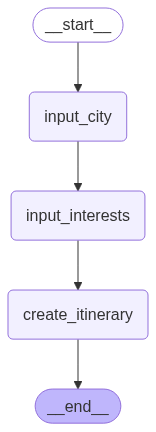

In [9]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Define the function that runs the graph

In [10]:
def run_travel_agent(user_request: str):
  print(f"Initial Request: {user_request}\n")
  state = {
      "messages": [HumanMessage(content=user_request)],
      "city": "",
      "interests": [],
      "itinerary": "",
  }
  for output in app.stream(state):
    pass # The nodes themselves now handle all printing

### Use case example

In [12]:
user_request = "I want to plan a day trip."
run_travel_agent(user_request)

Initial Request: I want to plan a day trip.

Please enter the city you want to visit:
Your input: paris
Please enter your interests for the trip to {state['city']} (comma-separate):
Your input: food
Creating an itinerary for paris based on interests: food...

Final Itinerary:
Bonjour! I'd be delighted to help you plan a foodie day trip to Paris. Here's a suggested itinerary for you:

**Morning**

* 9:00 AM: Start your day with a delicious French breakfast at Café de Flore or Les Deux Magots, two iconic cafes on the Boulevard Saint-Germain. Try a croissant or a baguette with butter and jam, accompanied by a café au lait or a hot chocolate.
* 10:00 AM: Visit the historic Marché aux Puces de Saint-Ouen (flea market) to explore the stalls selling artisanal foods, cheeses, and baked goods. You might find some unique and delicious treats to take back to your hotel or enjoy on the go.

**Lunch**

* 12:30 PM: Head to the charming neighborhood of Montmartre and grab lunch at Le Comptoir du Rela